In [ ]:
!pip install langgraph langgraph-sdk langgraph-checkpoint-sqlite langsmith langchain-community langchain-core langchain-openai tavily-python wikipedia


In [ ]:
import os
import operator
from datetime import datetime
from typing import Any, Annotated, List
from typing_extensions import TypedDict
from pydantic import BaseModel, Field

In [ ]:
from google.colab import userdata
from IPython.display import Image, display, Markdown
from langchain_core.tools import tool
from langchain_core.documents import Document
from langchain_core.messages import HumanMessage, SystemMessage, AIMessage, ToolMessage
from langchain_community.document_loaders import WikipediaLoader
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.utils.function_calling import convert_to_openai_function
from langchain.output_parsers.openai_functions import JsonOutputFunctionsParser

In [ ]:
from langgraph.graph import MessagesState
from langgraph.graph import StateGraph, START, END
from langgraph.prebuilt import ToolNode, tools_condition
from langgraph.checkpoint.memory import MemorySaver
from langchain_openai import ChatOpenAI
from langchain_community.retrievers import TavilySearchAPIRetriever

In [ ]:
openai_api_key = "OPENAI_API_KEY"
os.environ["OPENAI_API_KEY"] = "OPENAI_API_KEY"
os.environ["TAVILY_API_KEY"] = userdata.get('TAVILY_API_KEY')

In [ ]:
#LangSmith
os.environ["LANGCHAIN_API_KEY"] = userdata.get('LANGCHAIN_API_KEY')
os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_PROJECT"] = "Subgraphs"

In [ ]:
@tool
def web_search(query:str) -> dict:
  """Retrieve docs from web search"""

  # Search
  print(datetime.now(), "- Start Web search")
  tavily_search = TavilySearchResults(max_results = 3)
  search_docs = tavily_search.invoke(query)

  # Format
  formatted_search_docs = "\n---\n".join(
      [f'\n{doc["content"]}\n ' for doc in search_docs]
  )
  print(datetime.now(), "- End Web search")
  return {"context": [formatted_search_docs]}

In [ ]:

@tool
def wiki_search(query: str) -> dict:
  """Retrieve documents from wikipedia"""

  # Search
  print(datetime.now(), "- Start Wiki search")
  search_docs = WikipediaLoader(query=query, load_max_docs=2).load()

  # Format
  formatted_search_docs = "\n---\n".join(
      [f'\n{doc.page_content}\n' for doc in search_docs]
  )
  print(datetime.now(), "- End Wikipedia search")
  return {"context": [formatted_search_docs]}

In [ ]:
wiki_search.invoke("attention")


2025-02-13 10:13:22.672792 - Start Wiki search
2025-02-13 10:13:24.417038 - End Wikipedia search


{'context': ['\nAttention or focus, is the concentration of awareness on some phenomenon to the exclusion of other stimuli. It is the selective concentration on discrete information, either subjectively or objectively. William James (1890) wrote that "Attention is the taking possession by the mind, in clear and vivid form, of one out of what seem several simultaneously possible objects or trains of thought. Focalization, concentration, of consciousness are of its essence." Attention has also been described as the allocation of limited cognitive processing resources. Attention is manifested by an attentional bottleneck, in terms of the amount of data the brain can process each second; for example, in human vision, less than 1% of the visual input data stream of 1MByte/sec can enter the bottleneck, leading to inattentional blindness.\nAttention remains a crucial area of investigation within education, psychology, neuroscience, cognitive neuroscience, and neuropsychology. Areas of active 

# Graphs

In [ ]:
class Discussion(TypedDict):
  topic:  Annotated[list[str], operator.add]
  keywords:  Annotated[list[list], operator.add]
  expert:  Annotated[list, operator.add]
  search_expert: Annotated[list, operator.add]
  begginer:  Annotated[list, operator.add]
  search_begginer: Annotated[list, operator.add]
  discussion:  Annotated[list, operator.add]

# Build Sub-graphs

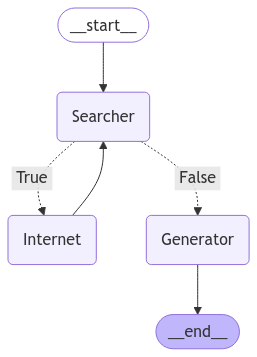

In [ ]:
# Expert subgraph
prompt_research_exp ="""You are an expert researcher. Use the search engine to find information on the Internet about the topic and related keywords that can help complement your research.
You can make multiple calls whenever you want (together or in sequence).
Your goal is to provide all the relevant information that you found, remember that you are an expert and be accurate."""

prompr_generator_exp = """You are an expert in creating articles, create one with the following topic and context in less than 600 words"""
# funtions
def generate_expert(state: Discussion):
  topic = state['topic']
  messages = [SystemMessage(content=prompr_generator_exp)] + [HumanMessage(content= "Topic: " + topic[0])] + state['search_expert']
  message = model_exp.invoke(messages)
  return {'expert': [message.content]}

def call_expert(state: Discussion):
  topic = state['topic']
  if state["search_expert"]:
    messages = [SystemMessage(content=prompt_research_exp)] + [HumanMessage(content="Topic: " + topic[0])] + [AIMessage(content="Keywords: " + ", ".join(state["keywords"][0]) )] + state['search_expert']
  else:
    messages = [SystemMessage(content=prompt_research_exp)] + [HumanMessage(content="Topic: " + topic[0])] + [AIMessage(content="Keywords: " + ", ".join(state["keywords"][0]) )]
  message = model_exp.invoke(messages)
  return {'search_expert': [message]}

def take_action_exp(state: Discussion):
  tool_calls = state['search_expert'][-1].tool_calls
  results = []
  for t in tool_calls:
    print(f"Calling: {t}")
    result = tools_exp[t['name']].invoke(t['args'])
    results.append(ToolMessage(tool_call_id=t['id'], name=t['name'], content=str(result)))
  return {'search_expert': results}

def need_to_search_exp(state: Discussion):
  result = state['search_expert'][-1]
  return len(result.tool_calls) > 0
# tools
tool_exp = [web_search]
tools_exp = {t.name: t for t in tool_exp}
model_exp = gpt_expert.bind_tools(tool_exp)

# Add nodes
builder_exp = StateGraph(Discussion)

builder_exp.add_node("Internet", take_action_exp)
builder_exp.add_node("Searcher", call_expert)
builder_exp.add_node("Generator", generate_expert)

# Flow
builder_exp.add_edge(START, "Searcher")
builder_exp.add_edge("Internet", "Searcher")
builder_exp.add_edge("Generator", END)
builder_exp.add_conditional_edges("Searcher", need_to_search_exp, {True:"Internet", False: "Generator" })

graph_exp = builder_exp.compile()
display(Image(graph_exp.get_graph().draw_mermaid_png()))

# Attention in Human Cognition: An Overview
Attention is a fundamental cognitive process that enables individuals to focus on specific stimuli while filtering out irrelevant information. This selective focus is crucial for navigating our complex environments, allowing us to prioritize tasks and manage cognitive resources effectively.


**Definition and Significance**
William James, a pioneering psychologist, described attention as "the taking possession by the mind, in clear and vivid form, of one out of what may seem several simultaneously possible objects or trains of thought." This definition highlights the essence of attention: it involves a conscious choice to engage with certain stimuli while withdrawing from others. This selective nature of attention is vital for effective functioning in daily life, influencing everything from learning to decision-making.


**Conclusion**
Attention is a vital cognitive function that shapes our perception and interaction with the world. By understanding its mechanisms and types, we can develop better strategies for enhancing focus and managing distractions, ultimately improving our cognitive performance in various aspects of life.

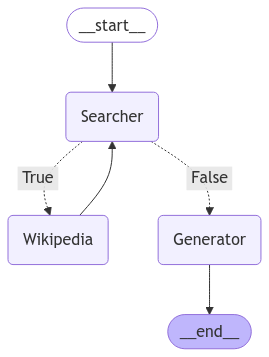

In [ ]:
# Begginer subgraph
prompt_research_beg ="""You are a novice researcher with a desire to learn more; use the search engine to find information on the topic.
You can make multiple calls whenever you want (together or in sequence).
Your goal is to provide all the relevant information you have found about topic."""

prompr_generator_beg = """You are and novice researcher, create an speech with the following topic and context, ask questions like if you want to learn more about and invite others to learn, use less than 600 words."""
# funtions
def generate_beg(state: Discussion):
  topic = state['topic']
  messages = [SystemMessage(content=prompr_generator_beg)] + [HumanMessage(content="Topic: " + topic[0])] + state['search_begginer']
  message = gpt_beg.invoke(messages)
  return {'begginer': [message.content]}

def call_beg(state: Discussion):
  topic = state['topic']
  if state["search_begginer"]:
    messages = [SystemMessage(content=prompt_research_beg)] + [HumanMessage(content="Topic: " + topic[0])] + state['search_begginer']
  else:
    messages = [SystemMessage(content=prompt_research_beg)] + [HumanMessage(content="Topic: " + topic[0])]
  message = model_beg.invoke(messages)
  return {'search_begginer': [message]}

def take_action_beg(state: Discussion):
  tool_calls = state['search_begginer'][-1].tool_calls
  results = []
  for t in tool_calls:
    print(f"Calling: {t}")
    result = tools_beg[t['name']].invoke(t['args'])
    results.append(ToolMessage(tool_call_id=t['id'], name=t['name'], content=str(result)))
  return {'search_begginer': results}

def need_to_search_beg(state: Discussion):
  result = state['search_begginer'][-1]
  return len(result.tool_calls) > 0

# tools
tool_beg = [wiki_search]
tools_beg = {t.name: t for t in tool_beg}
model_beg = gpt_beg.bind_tools(tool_beg)

# Add nodes
builder_beg = StateGraph(Discussion)

builder_beg.add_node("Wikipedia", take_action_beg)
builder_beg.add_node("Searcher", call_beg)
builder_beg.add_node("Generator", generate_beg)

# Flow
builder_beg.add_edge(START, "Searcher")
builder_beg.add_edge("Wikipedia", "Searcher")
builder_beg.add_edge("Generator", END)
builder_beg.add_conditional_edges("Searcher", need_to_search_beg, {True:"Wikipedia", False: "Generator" })

graph_beg = builder_beg.compile()

display(Image(graph_beg.get_graph().draw_mermaid_png()))

# Attention in Human Cognition


**Introduction** Good [morning/afternoon/evening], everyone! Today, I want to explore a fascinating topic that affects us all: attention in human cognition. Attention is not just about what we focus on; it shapes our experiences, learning, and interactions with the world around us.





**What is Attention**? At its core, attention is the process of concentrating awareness on specific stimuli while filtering out others. William James, a pioneering psychologist, described it as the "taking possession by the mind" of one out of several possible objects or thoughts. This selective focus is crucial because our brains can only process a limited amount of information at any given time.





**Why is Attention Important?** Attention plays a vital role in our daily lives. It helps us prioritize information, manage tasks, and navigate complex environments. For instance, when you're in a crowded room, your ability to focus on a single conversation while ignoring background noise is a testament to your attentional skills.





**Mechanisms of Attention** Let’s delve into some key concepts related to attention:





**Selective Attention**: This is our ability to focus on a particular object or task while ignoring distractions. Think about how you can read a book in a busy café; that’s selective attention at work!





**Inattentional Blindness:** Have you ever missed something obvious in your surroundings because you were focused on something else? This is known as inattentional blindness, where we fail to notice unexpected stimuli when our attention is directed elsewhere.





**Cognitive Resources:** Our brains have limited cognitive resources, meaning we can only process a small fraction of the information we encounter. This limitation necessitates prioritizing certain stimuli over others.





**Research and Applications** Attention is a significant area of study across various fields, including psychology, neuroscience, and education. Researchers are investigating how sensory cues influence attention and how attention interacts with other cognitive processes like memory.


Modern technologies, such as functional magnetic resonance imaging (fMRI), have allowed scientists to explore the neural networks involved in attention. This research has profound implications for understanding learning, mental health, and even artificial intelligence.




**Cultural Variations** Interestingly, attention can vary across cultures. Different cultural contexts can influence how individuals allocate their attention and process information. This raises intriguing questions about how our environments shape our cognitive processes.




**Historical** Context The study of attention has evolved significantly over time. Early philosophers, like Plato and Descartes, speculated about the nature of the mind. In the 20th century, cognitive psychology emerged, moving away from behaviorism, which largely ignored mental processes. This shift has led to a deeper understanding of attention and its complexities.




**Conclusion** In conclusion, attention is a fundamental aspect of human cognition that influences how we experience and interact with the world. By understanding its mechanisms and implications, we can enhance educational practices, improve mental health interventions, and even inform

# Main graph

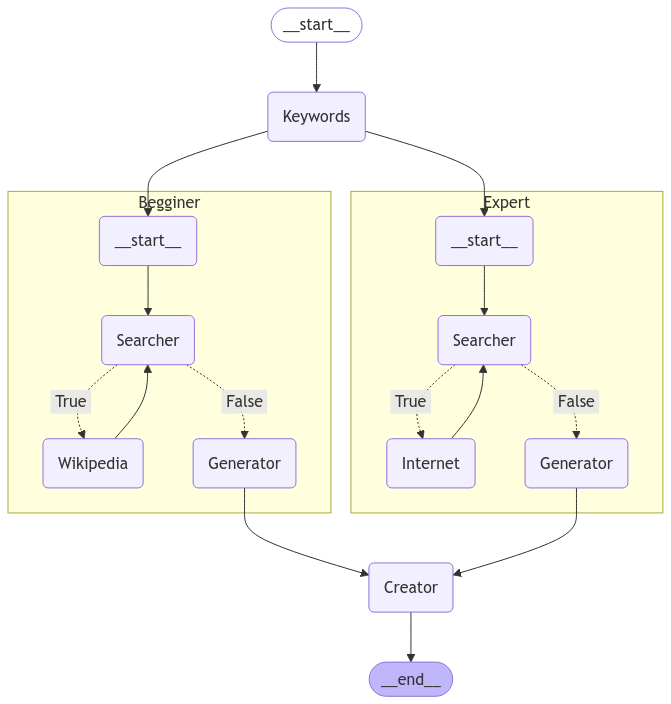

In [ ]:
# Main graph
prompt_diss = """ Your task is to create a discussion paper between the two following articles, one from an expert and the other from a beginner researcher.
Try to make it interesting with questions-answers and the opinion of the two people, be accurate and use less than 1100 words. """

# Functions
def search_for_keywords(state: Discussion):
  topic = state['topic']
  messages = [SystemMessage(content="Give me all the keywords related to the following topic")] + [HumanMessage(content="Topic: " + topic[0])]
  message = keywords_chain.invoke(messages)
  print(message["Category"])
  return {'keywords': [message["Category"]]}

def generate_disscusion(state: Discussion):
  print("Generating...")
  messages = [SystemMessage(content=prompt_diss)] + [HumanMessage(content="Expert researcher: " + state["expert"][0])] + [HumanMessage(content="Begginer researcher: " + state["begginer"][0])]
  message = gpt_creator.invoke(messages)
  return {'discussion': [message.content]}
# Add nodes

main_builder = StateGraph(Discussion)

main_builder.add_node("Expert", graph_exp)
main_builder.add_node("Begginer",  graph_beg)
main_builder.add_node("Keywords", search_for_keywords)
main_builder.add_node("Creator", generate_disscusion)

# Flow
main_builder.add_edge(START, "Keywords")
main_builder.add_edge("Keywords", "Expert")
main_builder.add_edge("Keywords", "Begginer")
main_builder.add_edge("Expert", "Creator")
main_builder.add_edge("Begginer", "Creator")
main_builder.add_edge("Creator", END)

graph_main = main_builder.compile()

# Setting xray to 1 will show the internal structure of the nested graph
display(Image(graph_main.get_graph(xray=1).draw_mermaid_png()))

In [ ]:
result_main = graph_main.invoke({"topic": ["What is Attention in human cognition"]})
display(Markdown(result_main["discussion"][0]))